In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import json
from datetime import datetime
from time import sleep
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import os


In [93]:
df = pd.read_csv('NAB/data/realKnownCause/ambient_temperature_system_failure.csv', parse_dates=['timestamp'])
print(df.head())
print(df.info())

            timestamp      value
0 2013-07-04 00:00:00  69.880835
1 2013-07-04 01:00:00  71.220227
2 2013-07-04 02:00:00  70.877805
3 2013-07-04 03:00:00  68.959400
4 2013-07-04 04:00:00  69.283551
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7267 non-null   datetime64[ns]
 1   value      7267 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 113.7 KB
None


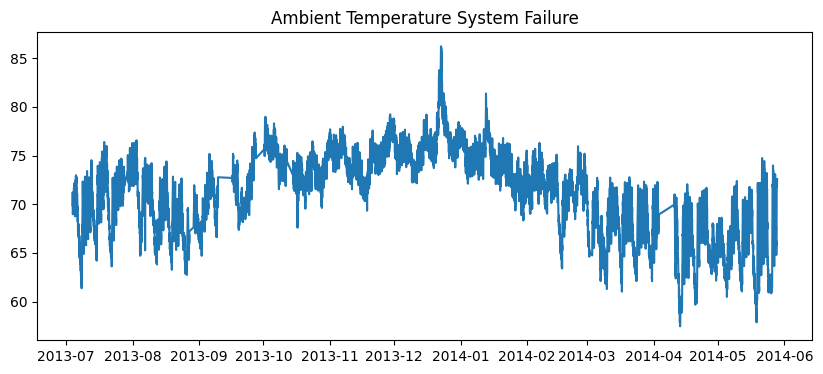

In [94]:
plt.figure(figsize=(10, 4))
plt.plot(df['timestamp'], df['value'])
plt.title("Ambient Temperature System Failure")
plt.show()

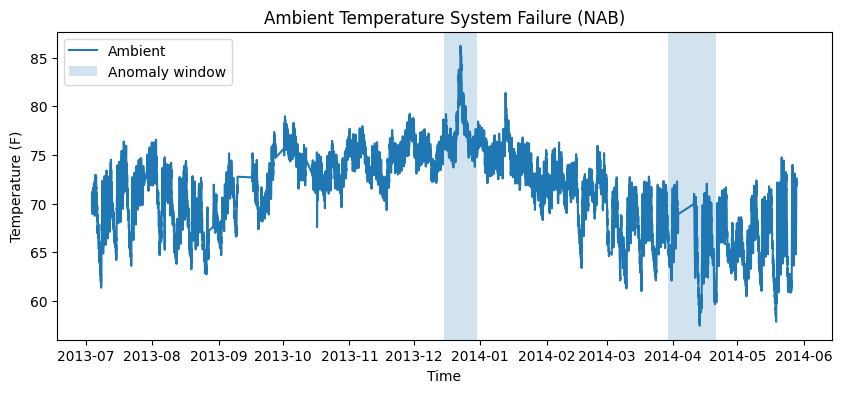

In [95]:
NAB_ROOT = "NAB"
AMBIENT_CSV = os.path.join(NAB_ROOT, "data/realKnownCause/ambient_temperature_system_failure.csv")
LABELS_JSON = os.path.join(NAB_ROOT, "labels/combined_windows.json")
AMBIENT_KEY = "realKnownCause/ambient_temperature_system_failure.csv"

shown = False

def coerce_windows_to_datetimes(win_list):
    out = []
    for w in win_list:
        if isinstance(w, (list, tuple)) and len(w) >= 2:
            start, end = w[0], w[1]
        elif isinstance(w, dict):
            start = w.get("start", w.get("Start", w.get("begin")))
            end = w.get("end", w.get("End", w.get("finish")))
        else:
            continue
        start = pd.to_datetime(start); end = pd.to_datetime(end)
        if pd.notna(start) and pd.notna(end) and end >= start:
            out.append((start, end))
    return out

df = pd.read_csv(AMBIENT_CSV)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.rename(columns={"value": "temperature"})

labels = json.load(open(LABELS_JSON))
windows = coerce_windows_to_datetimes(labels[AMBIENT_KEY])

plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["temperature"], label="Ambient")
for (ws, we) in windows:
    plt.axvspan(ws, we, alpha=0.2, label=None if shown else "Anomaly window"); shown = True
plt.title("Ambient Temperature System Failure (NAB)")
plt.xlabel("Time")
plt.ylabel("Temperature (F)")
plt.legend()
plt.show()


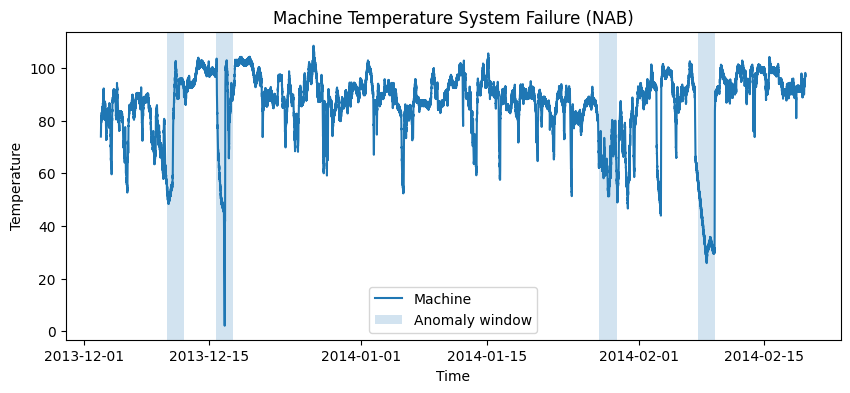

In [127]:
MACHINE_CSV = os.path.join(NAB_ROOT, "data/realKnownCause/machine_temperature_system_failure.csv")
MACHINE_KEY = "realKnownCause/machine_temperature_system_failure.csv"
shown = False
df = pd.read_csv(MACHINE_CSV)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.rename(columns={"value": "temperature"})

labels = json.load(open(LABELS_JSON))
windows = coerce_windows_to_datetimes(labels[MACHINE_KEY])

plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["temperature"], label="Machine")
for (ws, we) in windows:
    plt.axvspan(ws, we, alpha=0.2, label=None if shown else "Anomaly window"); shown = True
plt.title("Machine Temperature System Failure (NAB)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()




In [97]:
NAB_ROOT = "NAB"
MACHINE_CSV = os.path.join(NAB_ROOT, "data/realKnownCause/machine_temperature_system_failure.csv")

# Load machine dataset
df_machine = pd.read_csv(MACHINE_CSV)
df_machine['timestamp'] = pd.to_datetime(df_machine['timestamp'])
df_machine = df_machine.rename(columns={'value':'temperature'})


In [98]:
df_machine = df_machine.dropna(subset=['temperature'])


In [99]:
# Normalize Data
scaler = StandardScaler()
machine_scaled = scaler.fit_transform(df_machine[['temperature']])

# Train Test Split (50/50)
train_size = int(len(machine_scaled) * 0.5)
X_train = machine_scaled[:train_size]
X_all   = machine_scaled  # for later predictions

# Train IsolationForest Model
iso = IsolationForest(
    n_estimators=200,
    contamination=0.04,
    random_state=42
)
iso.fit(X_train)

# Predict anomalies on the machine dataset
df_machine['anomaly_score'] = iso.decision_function(X_all)
y_pred = iso.predict(X_all)
df_machine['is_anomaly'] = (y_pred == -1).astype(int)



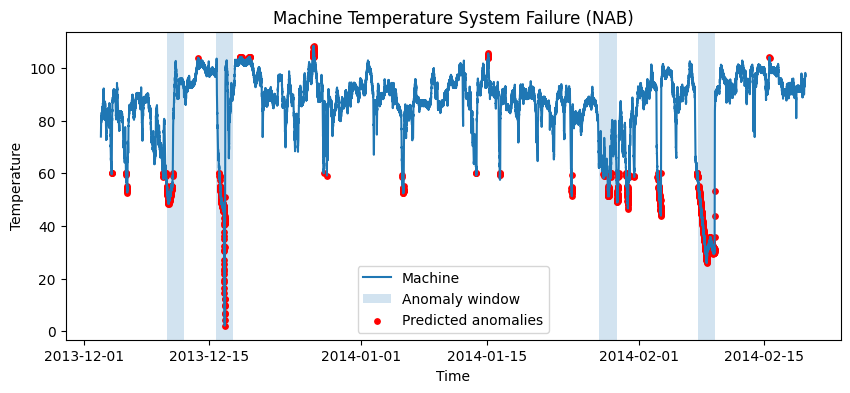

In [ ]:
if 'df_machine' in globals():
    df = df_machine.copy()
else:
    df = pd.read_csv(MACHINE_CSV)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.rename(columns={"value": "temperature"})

labels = json.load(open(LABELS_JSON))
windows = coerce_windows_to_datetimes(labels[MACHINE_KEY])

plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["temperature"], label="Machine")

shown = False
for (ws, we) in windows:
    plt.axvspan(ws, we, alpha=0.2, label=None if shown else "Anomaly window")
    shown = True
if 'is_anomaly' in df.columns:
    anoms = df[df['is_anomaly'] == 1]
    if not anoms.empty:
        plt.scatter(anoms['timestamp'], anoms['temperature'], s=15, color='red', label="Predicted anomalies")

plt.title("Machine Temperature System Failure (NAB)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Precision: 0.732
Recall:    0.407
F1-score:  0.523


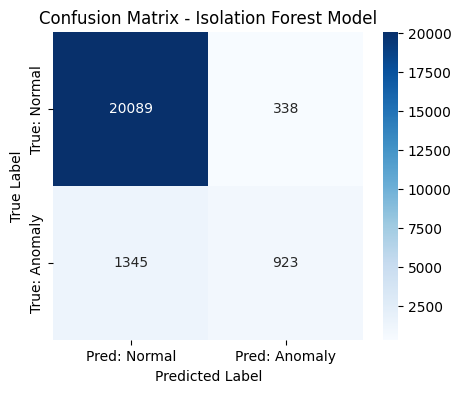

In [ ]:

df_machine['true_label'] = 0
for (ws, we) in windows:
    df_machine.loc[(df_machine['timestamp'] >= ws) & (df_machine['timestamp'] <= we), 'true_label'] = 1

y_true = df_machine['true_label'].values
y_pred = df_machine['is_anomaly'].values

cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# Anomaly Precision
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

# Heatmap Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Normal", "Pred: Anomaly"],
            yticklabels=["True: Normal", "True: Anomaly"])
plt.title("Confusion Matrix - Isolation Forest Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()



### SARIMA Model


In [102]:
# Normalize dataset on z score

EPS = 1e-6
def zscore(s): 
    return (s - s.mean()) / (s.std(ddof=0) + EPS)

df_ambient = df_ambient.sort_values('timestamp').reset_index(drop=True)
df_machine = df_machine.sort_values('timestamp').reset_index(drop=True)

df_ambient['z_temp'] = zscore(df_ambient['temperature'])
df_machine['z_temp'] = zscore(df_machine['temperature'])


In [103]:
yA = df_ambient['z_temp']

order_grid = [(p,d,q) for p in (0,1,2) for d in (0,1) for q in (0,1,2)]
best_aic, best_order, best_fit = np.inf, None, None

for order in order_grid:
    try:
        m = SARIMAX(yA, order=order, seasonal_order=(0,0,0,0),
                    enforce_stationarity=False, enforce_invertibility=False)
        f = m.fit(disp=False)
        if f.aic < best_aic:
            best_aic, best_order, best_fit = f.aic, order, f
    except Exception:
        pass

print(f"Best SARIMA order on Ambient: {best_order}, AIC={best_aic}")
sarima_fit = best_fit


c:\Users\Jason\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA order on Ambient: (2, 0, 2), AIC=-2296.3052208350437


In [124]:
n_steps = len(df_machine)
forecast_z = sarima_fit.forecast(steps=n_steps)

df_machine['sarima_forecast_z'] = forecast_z.values
df_machine['sarima_resid_z']    = df_machine['z_temp'].values - df_machine['sarima_forecast_z'].values

med = np.median(df_machine['sarima_resid_z'])
mad = np.median(np.abs(df_machine['sarima_resid_z'] - med)) + 1e-6
sigma_hat = 1.5 * mad
K = 4.5
df_machine['is_anomaly_sarima'] = (np.abs(df_machine['sarima_resid_z'] - med) > K * sigma_hat).astype(int)
print(f"Robust residual std ≈ {sigma_hat:.3f} (K={K})")


Robust residual std ≈ 0.579 (K=4.5)


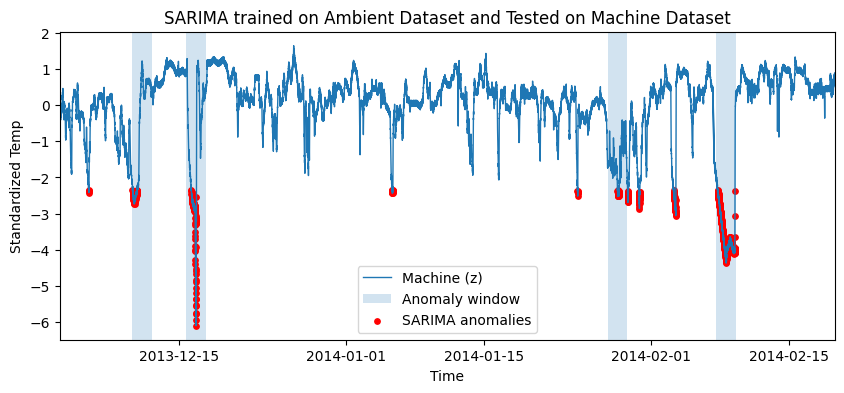

In [125]:
plt.figure(figsize=(10,4))
plt.plot(df_machine['timestamp'], df_machine['z_temp'], label='Machine (z)', lw=1)

if 'windows' in globals():
    shown = False
    tmin, tmax = df_machine['timestamp'].min(), df_machine['timestamp'].max()
    for (ws, we) in windows:
        ws_c, we_c = max(ws, tmin), min(we, tmax)
        if we_c >= ws_c:
            plt.axvspan(ws_c, we_c, alpha=0.2, label=None if shown else 'Anomaly window')
            shown = True

anoms = df_machine[df_machine['is_anomaly_sarima'] == 1]
if not anoms.empty:
    plt.scatter(anoms['timestamp'], anoms['z_temp'], s=15, color='red', label='SARIMA anomalies')

plt.xlim(df_machine['timestamp'].min(), df_machine['timestamp'].max())
plt.title('SARIMA trained on Ambient Dataset and Tested on Machine Dataset')
plt.xlabel('Time')
plt.ylabel('Standardized Temp')
plt.legend()
plt.show()


Precision: 0.846
Recall:    0.360
F1-score:  0.505


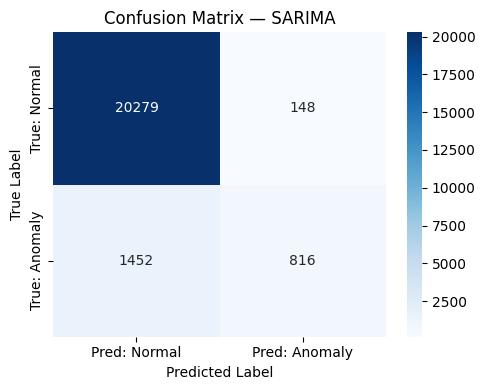

In [ ]:
# Check Labels for True Anomaly Data
if 'true_label' not in df_machine.columns and 'windows' in globals():
    df_machine['true_label'] = 0
    for (ws, we) in windows:
        mask = (df_machine['timestamp'] >= ws) & (df_machine['timestamp'] <= we)
        df_machine.loc[mask, 'true_label'] = 1

if 'true_label' in df_machine.columns:
    y_true = df_machine['true_label'].values
    y_pred = df_machine['is_anomaly_sarima'].values

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-score:  {f1:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Normal','Pred: Anomaly'],
                yticklabels=['True: Normal','True: Anomaly'])
    plt.title('Confusion Matrix — SARIMA')
    plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.tight_layout(); plt.show()
else:
    print("Ground-truth anomaly windows not defined. Please load `windows`.")
